In [92]:
import os
from pathlib import Path
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns

In [68]:
DATA_DIR = r'./Fish4Knowledge/fish_image'
image_dir = Path(DATA_DIR)
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
output = set()
for x in labels:
    output.add(x)
result = dict((i, labels.count(i)) for i in labels)
result = dict(sorted(result.items()))

In [69]:
fish_classification = {
    1: 'Dascyllus reticulatus',
    2: 'Plectroglyphidodon dickii',
    3: 'Chromis chrysura',
    4: 'Amphiprion clarkii',
    5: 'Chaetodon lunulatus',
    6: 'Chaetodon trifascialis',
    7: 'Myripristis kuntee',
    8: 'Acanthurus nigrofuscus',
    9: 'Hemigymnus fasciatus',
    10: 'Neoniphon sammara',
    11: 'Abudefduf vaigiensis',
    12: 'Canthigaster valentini',
    13: 'Pomacentrus moluccensis',
    14: 'Zebrasoma scopas',
    15: 'Hemigymnus melapterus',
    16: 'Lutjanus fulvus',
    17: 'Scolopsis bilineata',
    18: 'Scaridae',
    19: 'Pempheris vanicolensis',
    20: 'Zanclus cornutus',
    21: 'Neoglyphidodon nigroris',
    22: 'Balistapus undulatus',
    23: 'Siganus fuscescens'
}

In [70]:
values = list(result.values())
courses = list(result.keys())
courses = [int(fish.split('_')[1]) for fish in courses]
courses = [x for x in list(fish_classification.values())] 

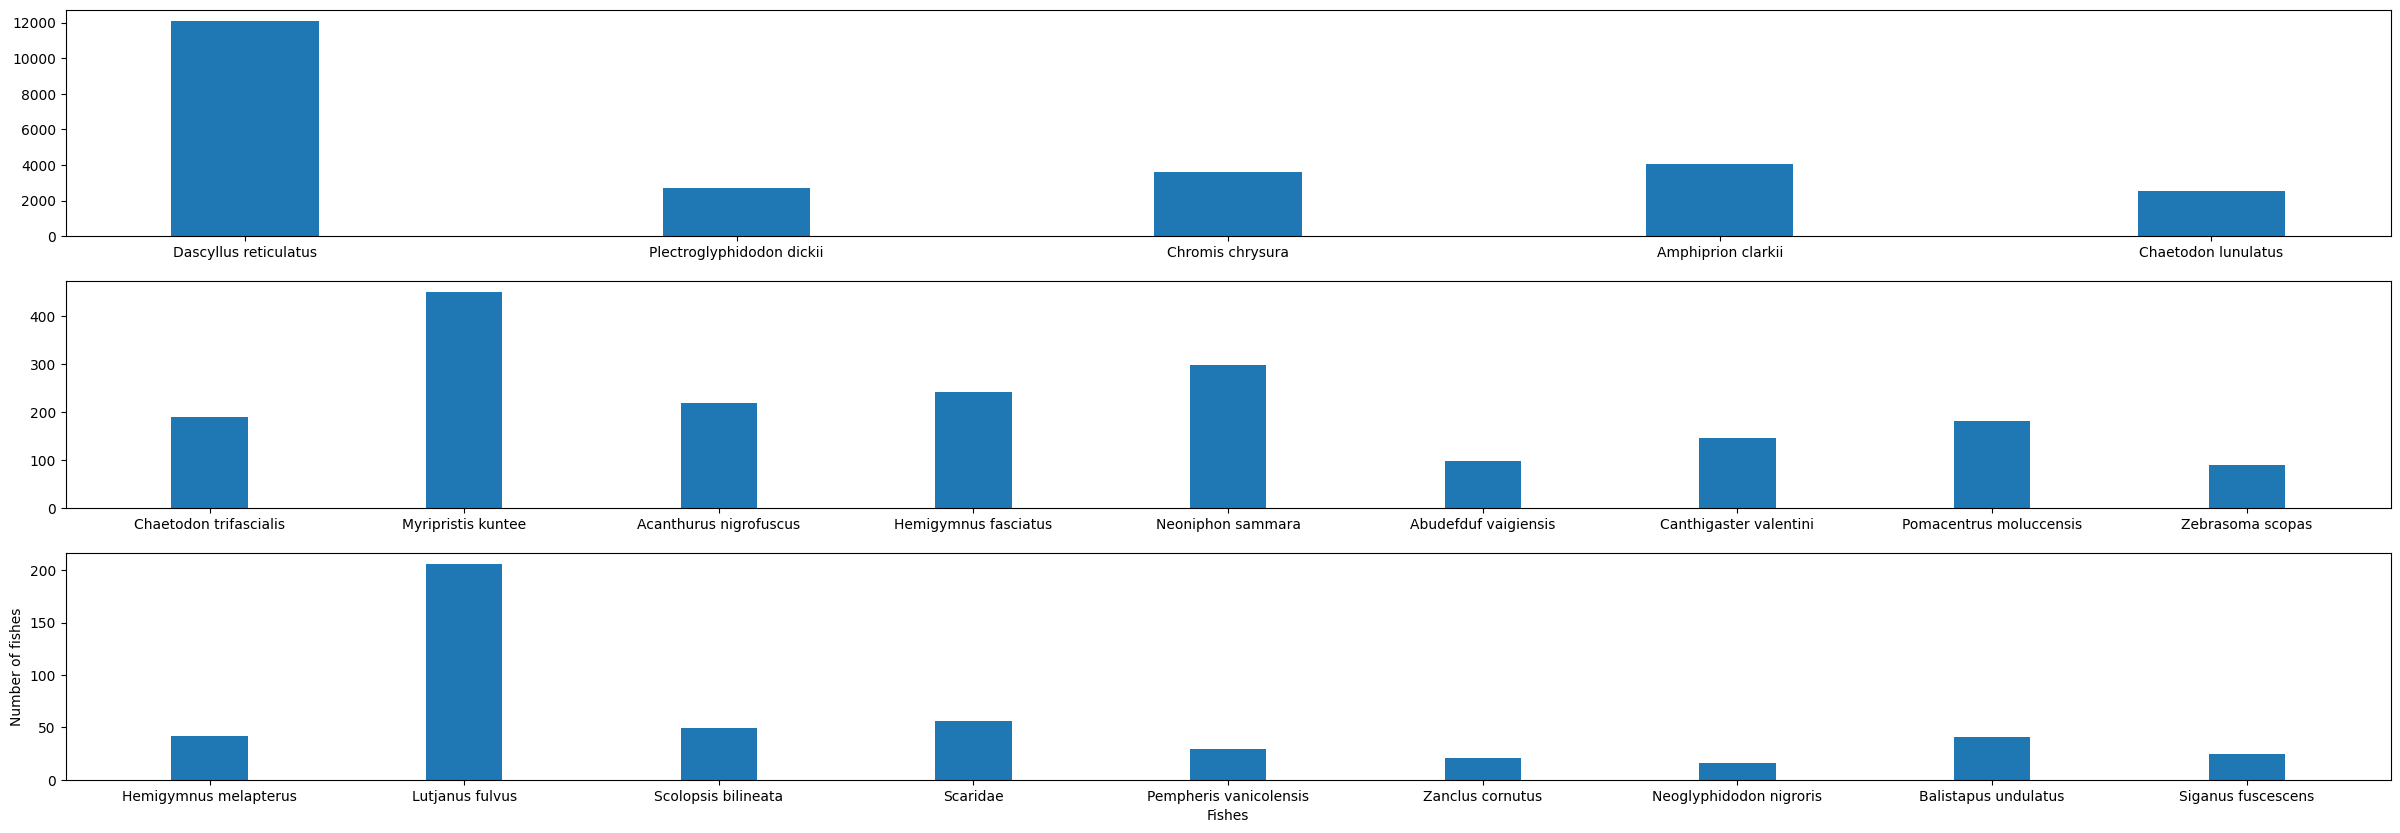

In [71]:
fig, axs = plt.subplots(3, figsize = (30, 10)) 
axs[0].bar(courses[:5], values[:5], 
        width = 0.3)

axs[1].bar(courses[5:14], values[5:14], 
        width = 0.3)

axs[2].bar(courses[14:], values[14:], 
        width = 0.3)

plt.xlabel("Fishes")
plt.ylabel("Number of fishes")
plt.show()

In [72]:
trans = transforms.Compose([transforms.Resize([128, 128]), # resize to a smaller size to avoid CUDA running out of memory
                            transforms.ToTensor()
                           ])
images = ImageFolder(root=DATA_DIR, transform=trans)

In [73]:
data_size = len(images)
test_size = int(0.2*data_size)
train_size = int(data_size-test_size)
print(f"number of classes: {len(images.classes)}")
print(f"total number of images: {data_size}")
print(f"total number of train images: {train_size}")
print(f"total number of test images: {test_size}")

train_set, test_set = random_split(images, (train_size, test_size))

number of classes: 23
total number of images: 27370
total number of train images: 21896
total number of test images: 5474


In [74]:
# show a single image
def show_image(img, label, dataset):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(dataset.classes[label])

# visualize a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

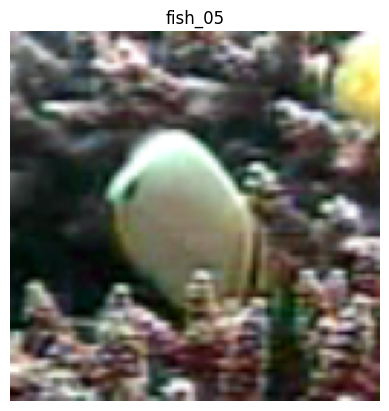

In [75]:
show_image(*test_set[1], test_set.dataset)

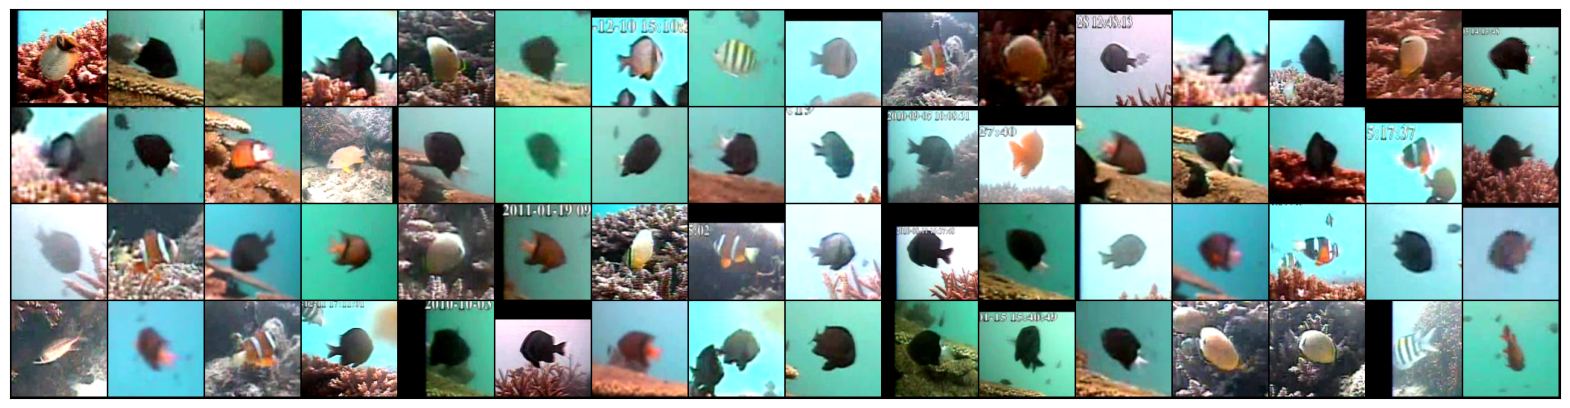

In [76]:
# create data loaders
batch_size = 64 # larger numbers lead to CUDA running out of memory
train_dl = DataLoader(train_set, batch_size=batch_size)
test_dl = DataLoader(test_set, batch_size=batch_size)

show_batch(train_dl)

In [77]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# CNN with residual connections
class FishResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512 * 4 * 4, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # add residual
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out # add residual
        out = self.classifier(out)
        return out

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device accordingly
model = FishResNet(3, 23).to(device) # 3 color channels and 23 output classes
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# model summary (helps in understanding the output shapes)
summary(model, (3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
├─Sequential: 1-2                        [-1, 128, 64, 64]         --
|    └─Conv2d: 2-4                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-5                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-6                         [-1, 128, 128, 128]       --
|    └─MaxPool2d: 2-7                    [-1, 128, 64, 64]         --
├─Sequential: 1-3                        [-1, 128, 64, 64]         --
|    └─Sequential: 2-8                   [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 64, 64]         147,584
|    |    └─BatchNorm2d: 3-2             [-1, 128, 64, 64]         256


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
├─Sequential: 1-2                        [-1, 128, 64, 64]         --
|    └─Conv2d: 2-4                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-5                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-6                         [-1, 128, 128, 128]       --
|    └─MaxPool2d: 2-7                    [-1, 128, 64, 64]         --
├─Sequential: 1-3                        [-1, 128, 64, 64]         --
|    └─Sequential: 2-8                   [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 64, 64]         147,584
|    |    └─BatchNorm2d: 3-2             [-1, 128, 64, 64]         256


In [79]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10
losses = []
for epoch in range(epochs):
    # for custom progress bar
    with tqdm(train_dl, unit="batch") as tepoch:
        epoch_loss = 0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            data, target = data.to(device), target.to(device) # move input to GPU
            out = model(data)
            loss = criterion(out, target)
            acc = multi_acc(out, target)
            epoch_loss += loss.item()
            loss.backward()
            optim.step()
            optim.zero_grad()
            tepoch.set_postfix(loss = loss.item(), accuracy = acc.item()) # show loss and accuracy per batch of data
    losses.append(epoch_loss)

Epoch 10: 100%|██████████| 343/343 [02:07<00:00,  2.69batch/s, accuracy=100, loss=5.44e-5]


In [80]:
y_pred_list = []
y_true_list = []
with torch.inference_mode():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            acc = multi_acc(y_test_pred, labels)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            tepoch.set_postfix(accuracy = acc.item())
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

100%|██████████| 86/86 [00:30<00:00,  2.83batch/s, accuracy=100]


In [81]:
# flatten prediction and true lists
flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")

number of testing samples results: 5474


In [84]:
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

Testing accuracy is: 97.81%


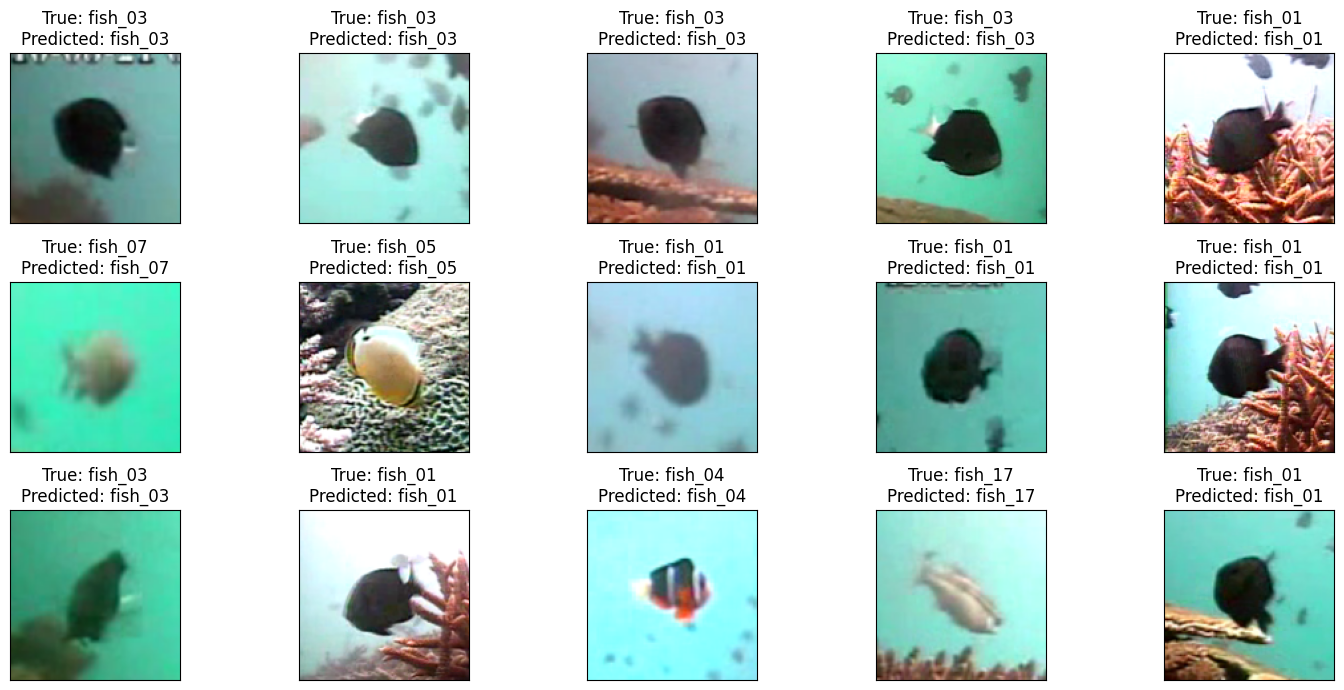

In [95]:
# Display 15 random picture of the dataset with their labels
inds = np.random.randint(len(test_set), size=15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in zip(inds, axes.flat):
    img, label = test_set[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {test_set.dataset.classes[label]}\nPredicted: {test_set.dataset.classes[flat_pred[i]]}")
plt.tight_layout()
plt.show()